# Install pytorch
This exercise requires [pytorch](https://pytorch.org). To install it:

1. Activate your virtual environment:
   ```sh
   conda activate flygym
   ```
2. Install pytorch with pip:
   ```sh
   pip install torch
   ```

For details on how to use pytorch, refer to the [pytorch tutorials](https://pytorch.org/tutorials/).

# Exercise 2: Neural network
The basic center of mass tracking method that we used in the [vision tutorial](1_vision.ipynb) might fail for objects that blend in closely with the background. In this exercise, we will introduce a second fly into the arena and deploy a neural network to accurately track its location.

For the neural network to learn, it's essential to first compile a dataset containing images along with the precise locations of this additional fly. This has been implemented in [collect_data.py](collect_data.py). The script requires a few minutes to execute. To speed up the process, the dataset have already been generated and saved in [data/data.npz](data/data.npz).

Now, we will proceed to load the dataset:

In [1]:
import numpy as np

data = np.load("data/data.npz")
images = data["images"]
# The images are stored in a 4D array (n_images, n_eyes, n_rows, n_cols)
print(f"Shape of images: {images.shape}")
# The positions of the second fly are stored in polar coordinates (r, theta)
r = data["r"]
theta = data["theta"]
data.close()

Shape of images: (10000, 2, 16, 31)


We will convert the position of the fly from polar coordinates $(r, \theta)$ into a Cartesian coordinate system that has undergone rotation and inversion. The two basis vectors point at 45° to the left and right of the fly, respectively.

<img src="images/coordinates.png" width="600">

Implement the conversion below. What is the advantage of this encoding?

In [2]:
################################################################
# TODO: Convert the polar coordinates to cartesian coordinates
coords_lr = r * np.exp(1j * (np.pi / 4 - theta))
coords_lr = np.column_stack([coords_lr.real, coords_lr.imag])
################################################################

# The shape should be (# of samples, 2)
assert coords_lr.shape == (len(images), 2)

Next, we can create the data loaders:

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(torch.tensor(images), torch.tensor(coords_lr))
datasets = dict(
    zip(["train", "val", "test"], random_split(dataset, [8000, 1000, 1000]))
)
batch_size = 32
loaders = {
    name: DataLoader(dataset, batch_size=batch_size, shuffle=name == "train")
    for name, dataset in datasets.items()
}

Construct your neural network model in the following cell. A simple Convolutional Neural Network (CNN) should be enough for achieving good performance on this dataset.

In [4]:
from torch import nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #########################################
        # TODO: Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)
        self.fc1 = nn.LazyLinear(16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        #########################################

    def forward(self, x):
        #########################################
        # TODO: Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))
        x = x.max(-2)[0]
        x = x.flatten(1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
        #########################################

In [5]:
from copy import deepcopy
import torch.optim as optim

model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float("inf")

for epoch in range(100):
    model.train()

    train_loss = 0

    for inputs, labels in loaders["train"]:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loaders["train"])

    model.eval()

    with torch.no_grad():
        val_loss = 0
        for inputs, labels in loaders["val"]:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(loaders["val"])

    print(f"{epoch=}, {train_loss=:0.4f}, {val_loss=:0.4f}")

    if val_loss < best_val_loss:
        best_model_state = deepcopy(model.state_dict())
        best_val_loss = val_loss

model.load_state_dict(best_model_state)

epoch=0, train_loss=19.4081, val_loss=18.9356
epoch=1, train_loss=10.4939, val_loss=5.7080
epoch=2, train_loss=5.0179, val_loss=5.6384
epoch=3, train_loss=4.7349, val_loss=4.9436
epoch=4, train_loss=4.5352, val_loss=4.7391
epoch=5, train_loss=4.4606, val_loss=4.7526
epoch=6, train_loss=4.3658, val_loss=4.7644
epoch=7, train_loss=4.3474, val_loss=4.5562
epoch=8, train_loss=4.2679, val_loss=4.6017
epoch=9, train_loss=4.2267, val_loss=4.4618
epoch=10, train_loss=4.1429, val_loss=4.5459
epoch=11, train_loss=4.0429, val_loss=4.4020
epoch=12, train_loss=4.0136, val_loss=4.3242
epoch=13, train_loss=3.9134, val_loss=4.1908
epoch=14, train_loss=3.8336, val_loss=4.1616
epoch=15, train_loss=3.7269, val_loss=4.0029
epoch=16, train_loss=3.6041, val_loss=3.8884
epoch=17, train_loss=3.5022, val_loss=4.0308
epoch=18, train_loss=3.3707, val_loss=3.5724
epoch=19, train_loss=3.2340, val_loss=3.4950
epoch=20, train_loss=3.0578, val_loss=3.2557
epoch=21, train_loss=2.8899, val_loss=3.0720
epoch=22, train_l

<All keys matched successfully>

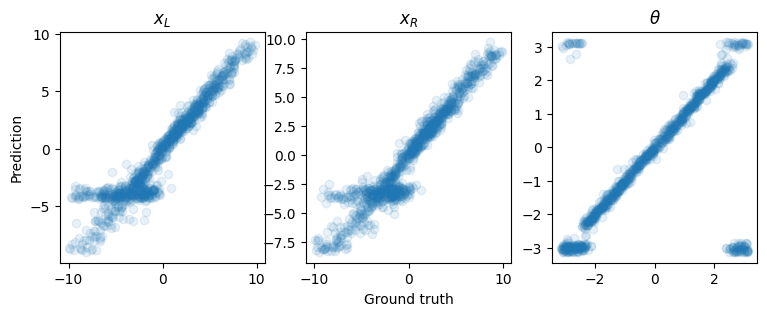

In [6]:
import matplotlib.pyplot as plt

test_indices = datasets["test"].indices
with torch.no_grad():
    coords_lr_pred = model(torch.tensor(images[test_indices])).numpy()

theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(2):
    axs[i].scatter(coords_lr[test_indices, i], coords_lr_pred[:, i], alpha=0.1)

axs[2].scatter(theta[test_indices], theta_pred, alpha=0.1)

axs[0].set_ylabel("Prediction")
axs[1].set_xlabel("Ground truth")

for ax, title in zip(axs, ["$x_L$", "$x_R$", "$\\theta$"]):
    ax.set_title(title)

Can you estimate the visual field of the fly based on the plots?

In this exercise, we have learned how to
- Create image datasets with NeuroMechFly simulation
- Use neural networks to estimate object position